### Comparing regression plots
1. Calculate instantaneous regression, maximum regression, and lag of maximum regression for mean precipitation
2. Calculate instantaneous regression, maximum regression, and lag of maximum regression for Rx1day
3. Compare sign of intantaneous regression and maximum regression plots
4. Calculate difference between lags 

### Imports

In [1]:
import xarray as xr
import numpy as np
import sys
sys.path.append('/home/563/rl5183/PhD-research/Functions')
import functions as func
from importlib import reload
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

### Data

In [2]:
# HadISST 1948-2017
hadisst_ds = xr.open_dataset('/g/data/eg3/jxb548/OBSDATA/hadisstv1.1870_2017.nc')
sst_data = hadisst_ds.sst
# CMAP precip
precip_ds = xr.open_dataset('/g/data/ua8/Precipitation/CMAP/std/precip.mon.mean.nc')
precip_data = precip_ds.precip[:,::-1,:] # reverse lat dimension 
# Rx1day from HadEX3 (regridded to match mean precip data)
Rx1_ds = xr.open_dataset('/g/data/w40/rl5183/HadEX3_Rx1day_MON_regrid_144x72.nc')
Rx1 = Rx1_ds.Rx1day.sel(time=slice('1948-11', '2016-10'))

### Detrend

In [3]:
# Detrend HadISST data
sst_data_detrend = np.apply_along_axis(func.detrend_2step, 0, sst_data)
sst_detrended = xr.DataArray(sst_data_detrend, coords=sst_data.coords, attrs=sst_data.attrs)

### Calculate Nino3.4 index 

In [4]:
nino34_region = sst_detrended.sel(latitude=slice(5,-5), longitude=slice(-170,-120))
climatology = nino34_region.sel(time=slice('1950-01','1979-12')).groupby('time.month').mean()
monthly_anomalies = (nino34_region.groupby('time.month')-climatology).mean(dim=['latitude','longitude'])
monthly_anomalies_rolling = monthly_anomalies.rolling(time=5).mean()
sst_std = nino34_region.sel(time=slice('1950-01','1979-12')).std()
nino34_index = monthly_anomalies_rolling.sel(time=slice('1948-11', '2016-10'))/sst_std

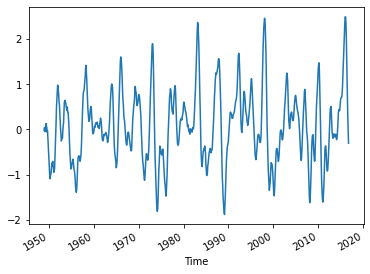

In [5]:
nino34_index.plot()

### Calculate monthly precip anomalies

In [6]:
# Calculate monthly precip anomalies 
climatology = precip_data.sel(time=slice('1979','2008')).groupby('time.month').mean()
precip_anom = precip_data.groupby('time.month')-climatology 
# Smooth with 3-month running mean
precip_anom_rolling = precip_anom.rolling(time=3).mean().sel(time=slice('1979-11', '2016-10'))

### Calculate instantaneous regression

In [7]:
# The mean over every quarter, (starting with nov, can start at dec for seasonal mean)
quarterly_precip_anom = precip_anom_rolling.resample(time='QS-NOV').mean('time')
quarterly_nino = nino34_index.resample(time='QS-NOV').mean('time')
# The max over every quarter, starting at nov 
quarterly_max_Rx1 = Rx1.resample(time='QS-NOV').max('time')
# Select out NDJ nino34 index
nino_ndj = quarterly_nino.isel(time=slice(0,None,4))

In [8]:
# The regression for each quarter between precip_anom and nino
quarterly_regression_mean = func.regress_nino_by_month(quarterly_precip_anom, nino_ndj.sel(time=slice('1979-11', '2016-10')))
# The regression for each quarter between max Rx1 and nino
quarterly_regression_extreme = func.regress_nino_by_month(quarterly_max_Rx1, nino_ndj)

### Calculate maximum regression

In [9]:
# SHIFT TIMSERIES SO J,J,A,S,O,N IN YEAR 0 AND J,F,M,A,M IN YEAR 1
precip_anom_lag = precip_anom.rolling(time=3).mean().sel(time=slice('1979-06', '2016-05'))
Rx1_lag = Rx1_ds.Rx1day.sel(time=slice('1948-06', '2016-05'))

In [10]:
# Calculate NDJ nino34 regression onto each month using regress nino function
monthly_regression_mean = func.regress_nino_by_month(precip_anom_lag, nino_ndj.sel(time=slice('1979-11', '2016-10')))
monthly_regression_extreme = func.regress_nino_by_month(Rx1_lag, nino_ndj)

In [11]:
# Find maximum across all months and month in which maximum occurs for mean
mean_stack = np.dstack((monthly_regression_mean.sel(month=6), 
                       monthly_regression_mean.sel(month=7), 
                       monthly_regression_mean.sel(month=8),
                       monthly_regression_mean.sel(month=9),
                       monthly_regression_mean.sel(month=10),
                       monthly_regression_mean.sel(month=11),
                       monthly_regression_mean.sel(month=12),
                       monthly_regression_mean.sel(month=1),
                       monthly_regression_mean.sel(month=2),
                       monthly_regression_mean.sel(month=3),
                       monthly_regression_mean.sel(month=4),
                       monthly_regression_mean.sel(month=5)))
# Find maximum across all months
max_regression_mean = mean_stack.max(2)
min_regression_mean = mean_stack.min(2)
# Find month of max
max_month_mean = mean_stack.argmax(2) +1
min_month_mean = mean_stack.argmin(2) +1

# Find maximum across all months and month in which maximum occurs for extreme
extreme_stack = np.dstack((monthly_regression_extreme.sel(month=6), 
                       monthly_regression_extreme.sel(month=7), 
                       monthly_regression_extreme.sel(month=8),
                       monthly_regression_extreme.sel(month=9),
                       monthly_regression_extreme.sel(month=10),
                       monthly_regression_extreme.sel(month=11),
                       monthly_regression_extreme.sel(month=12),
                       monthly_regression_extreme.sel(month=1),
                       monthly_regression_extreme.sel(month=2),
                       monthly_regression_extreme.sel(month=3),
                       monthly_regression_extreme.sel(month=4),
                       monthly_regression_extreme.sel(month=5)))
# Find maximum across all months
max_regression_extreme = extreme_stack.max(2)
min_regression_extreme = extreme_stack.min(2)
# Find month of max
max_month_extreme = extreme_stack.argmax(2) +1
min_month_extreme = extreme_stack.argmin(2) +1

In [12]:
# Find absolute max of max_regression and min_regression, recording month for mean
abs_max_mean = np.empty(shape=np.shape(max_regression_mean))
months_mean = np.empty(shape=np.shape(max_month_mean))

for i in np.arange(0,np.shape(max_regression_mean)[0]):
    for j in np.arange(0,np.shape(max_regression_mean)[1]):
        if abs(max_regression_mean[i,j]) > abs(min_regression_mean[i,j]):
            abs_max_mean[i,j] = max_regression_mean[i,j]
            months_mean[i,j] = max_month_mean[i,j]
        elif abs(max_regression_mean[i,j]) < abs(min_regression_mean[i,j]):
            abs_max_mean[i,j] = min_regression_mean[i,j]
            months_mean[i,j] = min_month_mean[i,j]
        else:
            abs_max_mean[i,j] = np.NaN
            months_mean[i,j] = np.NaN
            
# Find absolute max of max_regression and min_regression, recording month for extreme
abs_max_extreme = np.empty(shape=np.shape(max_regression_extreme))
months_extreme = np.empty(shape=np.shape(max_month_extreme))

for i in np.arange(0,np.shape(max_regression_extreme)[0]):
    for j in np.arange(0,np.shape(max_regression_extreme)[1]):
        if abs(max_regression_extreme[i,j]) > abs(min_regression_extreme[i,j]):
            abs_max_extreme[i,j] = max_regression_extreme[i,j]
            months_extreme[i,j] = max_month_extreme[i,j]
        elif abs(max_regression_extreme[i,j]) < abs(min_regression_extreme[i,j]):
            abs_max_extreme[i,j] = min_regression_extreme[i,j]
            months_extreme[i,j] = min_month_extreme[i,j]
        else:
            abs_max_extreme[i,j] = np.NaN
            months_extreme[i,j] = np.NaN

In [13]:
# Convert to xarray
sample = precip_anom_rolling.mean('time')
maximum_regression_mean = xr.DataArray(abs_max_mean, coords=sample.coords, attrs=sample.attrs)
month_of_max_regression_mean = xr.DataArray(months_mean, coords=sample.coords, attrs=sample.attrs)

sample2 = Rx1.mean('time')
maximum_regression_extreme = xr.DataArray(abs_max_extreme, coords=sample2.coords, attrs=sample2.attrs)
month_of_max_regression_extreme = xr.DataArray(months_extreme, coords=sample2.coords, attrs=sample2.attrs)

### Calculate sign comparison between mean and extreme 

In [14]:
inst_regression_sign_comp_np = func.sign_corr(quarterly_regression_mean.sel(month=11), quarterly_regression_extreme.sel(month=11))
max_regression_sign_comp_np = func.sign_corr(maximum_regression_mean, maximum_regression_extreme)
# Convert to xarray
inst_regression_sign_comp = xr.DataArray(inst_regression_sign_comp_np, coords=sample.coords, attrs=sample.attrs)
max_regression_sign_comp = xr.DataArray(max_regression_sign_comp_np, coords=sample.coords, attrs=sample.attrs)

### Calculate difference in lag

In [15]:
lag_diff = month_of_max_regression_mean - month_of_max_regression_extreme

### Create colorbars 

In [16]:
# Lag
cmap_lag = mpl.colors.ListedColormap(['forestgreen', 'mediumseagreen', 'mediumaquamarine', 'paleturquoise', 'lightcyan', 'azure', 'white', 'lavenderblush', 'pink', 'palevioletred', 'mediumvioletred', 'crimson'])
bounds_lag = np.arange(0,13)
norm_lag = mpl.colors.BoundaryNorm(bounds_lag+0.5, cmap_lag.N)

# Sign comparison 
cmap_sign = mpl.colors.ListedColormap(['red', 'blue', 'darkviolet', 'mediumpurple', 'lightgrey'])
bounds_sign = np.arange(-1,5)
norm_sign = mpl.colors.BoundaryNorm(bounds_sign+0.5, cmap_sign.N)

### Plot instantaneous regression, maximum regression, and lag for mean

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.01/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.01/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


[Text(1, 1.0, 'Jun (0)'),
 Text(1, 2.0, 'Jul (0)'),
 Text(1, 3.0, 'Aug (0)'),
 Text(1, 4.0, 'Sep (0)'),
 Text(1, 5.0, 'Oct (0)'),
 Text(1, 6.0, 'Nov (0)'),
 Text(1, 7.0, 'Dec (0)'),
 Text(1, 8.0, 'Jan (+1)'),
 Text(1, 9.0, 'Feb (+1)'),
 Text(1, 10.0, 'Mar (+1)'),
 Text(1, 11.0, 'Apr (+1)'),
 Text(1, 12.0, 'May (+1)')]

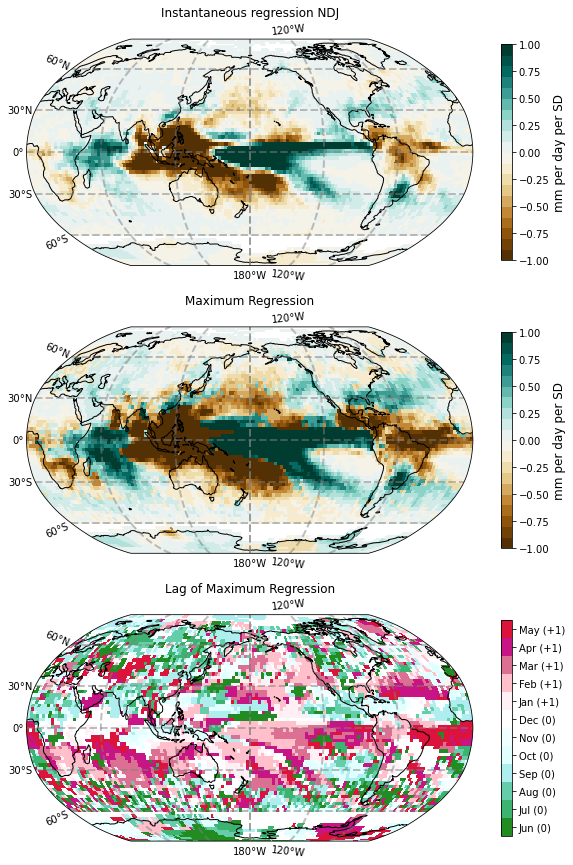

In [17]:
fig = plt.figure(figsize=(10,15))

vmin=-1
vmax=1

ax = fig.add_subplot(311, projection=ccrs.Robinson(180))
C = quarterly_regression_mean.sel(month=11).plot(ax=ax, vmin=vmin, vmax=vmax, add_colorbar=False, transform=ccrs.PlateCarree(), cmap=plt.cm.get_cmap('BrBG', 20))
ax.coastlines()
ax.set_global()
ax.set_title('Instantaneous regression NDJ')
# Gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
# Colorbar
cbar = plt.colorbar(C, ax=ax, shrink=0.9, pad=0.05)
cbar.ax.set_ylabel('mm per day per SD', fontsize=12)

ax = fig.add_subplot(312, projection=ccrs.Robinson(180))
C = maximum_regression_mean.plot(ax=ax, vmin=vmin, vmax=vmax, add_colorbar=False, transform=ccrs.PlateCarree(), cmap=plt.cm.get_cmap('BrBG', 20))
ax.coastlines()
ax.set_global()
ax.set_title('Maximum Regression')
# Gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
# Colorbar
cbar = plt.colorbar(C, ax=ax, shrink=0.9, pad=0.05)
cbar.ax.set_ylabel('mm per day per SD', fontsize=12)

ax = fig.add_subplot(313, projection=ccrs.Robinson(180))
C = month_of_max_regression_mean.plot(ax=ax, add_colorbar=False, transform=ccrs.PlateCarree(), cmap=cmap_lag, norm=norm_lag, levels=bounds_lag+0.5)
ax.coastlines()
ax.set_global()
ax.set_title('Lag of Maximum Regression')
# Gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
# Colorbar 
cbar = plt.colorbar(C, ax=ax, ticks=bounds_lag, shrink=0.9, pad=0.05)
cbar.ax.set_yticklabels(['Jun (0)', 'Jul (0)', 'Aug (0)', 'Sep (0)', 'Oct (0)', 'Nov (0)', 'Dec (0)', 'Jan (+1)', 'Feb (+1)', 'Mar (+1)', 'Apr (+1)', 'May (+1)'])

# Save figure
# plt.savefig('maximum_regression_temp.jpg', bbox_inches='tight', dpi=300, quality=80, optimize=True, progressive=True)

### Plot instantaneous regression, maximum regression, and lag for extreme

[Text(1, 1.0, 'Jun (0)'),
 Text(1, 2.0, 'Jul (0)'),
 Text(1, 3.0, 'Aug (0)'),
 Text(1, 4.0, 'Sep (0)'),
 Text(1, 5.0, 'Oct (0)'),
 Text(1, 6.0, 'Nov (0)'),
 Text(1, 7.0, 'Dec (0)'),
 Text(1, 8.0, 'Jan (+1)'),
 Text(1, 9.0, 'Feb (+1)'),
 Text(1, 10.0, 'Mar (+1)'),
 Text(1, 11.0, 'Apr (+1)'),
 Text(1, 12.0, 'May (+1)')]

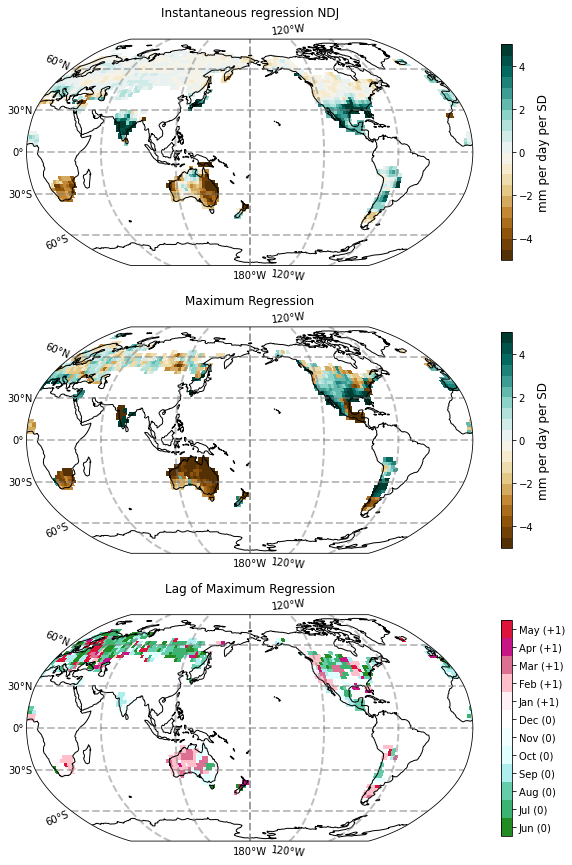

In [18]:
fig = plt.figure(figsize=(10,15))

vmin=-5
vmax=5

ax = fig.add_subplot(311, projection=ccrs.Robinson(180))
C = quarterly_regression_extreme.sel(month=11).plot(ax=ax, vmin=vmin, vmax=vmax, add_colorbar=False, transform=ccrs.PlateCarree(), cmap=plt.cm.get_cmap('BrBG', 20))
ax.coastlines()
ax.set_global()
ax.set_title('Instantaneous regression NDJ')
# Gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
# Colorbar
cbar = plt.colorbar(C, ax=ax, shrink=0.9, pad=0.05)
cbar.ax.set_ylabel('mm per day per SD', fontsize=12)

ax = fig.add_subplot(312, projection=ccrs.Robinson(180))
C = maximum_regression_extreme.plot(ax=ax, vmin=vmin, vmax=vmax, add_colorbar=False, transform=ccrs.PlateCarree(), cmap=plt.cm.get_cmap('BrBG', 20))
ax.coastlines()
ax.set_global()
ax.set_title('Maximum Regression')
# Gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
# Colorbar
cbar = plt.colorbar(C, ax=ax, shrink=0.9, pad=0.05)
cbar.ax.set_ylabel('mm per day per SD', fontsize=12)

ax = fig.add_subplot(313, projection=ccrs.Robinson(180))
C = month_of_max_regression_extreme.plot(ax=ax, add_colorbar=False, transform=ccrs.PlateCarree(), cmap=cmap_lag, norm=norm_lag, levels=bounds_lag+0.5)
ax.coastlines()
ax.set_global()
ax.set_title('Lag of Maximum Regression')
# Gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
# Colorbar 
cbar = plt.colorbar(C, ax=ax, ticks=bounds_lag, shrink=0.9, pad=0.05)
cbar.ax.set_yticklabels(['Jun (0)', 'Jul (0)', 'Aug (0)', 'Sep (0)', 'Oct (0)', 'Nov (0)', 'Dec (0)', 'Jan (+1)', 'Feb (+1)', 'Mar (+1)', 'Apr (+1)', 'May (+1)'])

# Save figure
# plt.savefig('maximum_regression_precip.jpg', bbox_inches='tight', dpi=300, quality=80, optimize=True, progressive=True)

### Plot comparison between mean and extreme

[Text(1, 0.0, 'Both Positive'),
 Text(1, 1.0, 'Both Negative'),
 Text(1, 2.0, 'Mean Pos/Ex Neg'),
 Text(1, 3.0, 'Mean Neg/Ex Pos'),
 Text(1, 4.0, 'NaN')]

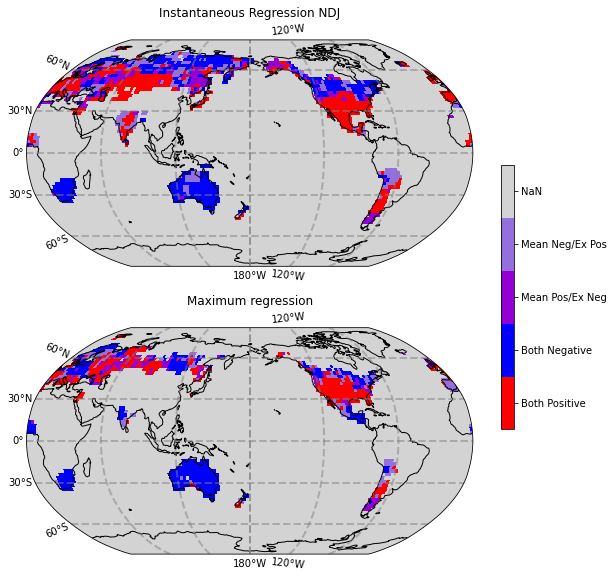

In [25]:
fig = plt.figure(figsize=(10,15))
axs = []

ax = fig.add_subplot(311, projection=ccrs.Robinson(180))
C = inst_regression_sign_comp.plot(ax=ax, add_colorbar=False, transform=ccrs.PlateCarree(), cmap=cmap_sign, norm=norm_sign, levels=bounds_sign+0.5)
ax.coastlines()
ax.set_global()
ax.set_title('Instantaneous Regression NDJ')
axs.append(ax)
# Gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

ax = fig.add_subplot(312, projection=ccrs.Robinson(180))
C = max_regression_sign_comp.plot(ax=ax, add_colorbar=False, transform=ccrs.PlateCarree(), cmap=cmap_sign, norm=norm_sign, levels=bounds_sign+0.5)
ax.coastlines()
ax.set_global()
ax.set_title('Maximum regression')
axs.append(ax)
# Gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

# Colorbar 
cbar = plt.colorbar(C, ax=axs, ticks=bounds_sign, shrink=0.5, pad=0.05)
cbar.ax.set_yticklabels(['Both Positive', 'Both Negative', 'Mean Pos/Ex Neg', 'Mean Neg/Ex Pos', 'NaN'])

# Add change in lag, think need to change lat first??